In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import datetime
from PIL import Image
s = tf.InteractiveSession()

TensorFlow 1.x selected.


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/DL-HW1/Q1_train.csv')
data_test = pd.read_csv('/content/drive/My Drive/DL-HW1/Q1_test.csv')

In [4]:
#Getting the labels
labels = data.iloc[:,0]
labels_t = data_test.iloc[:,0]
data.drop(columns = ['label'],inplace = True)
data_test.drop(columns = ['label'],inplace = True)
#standarizing
data = data/255
data_test = data_test/255

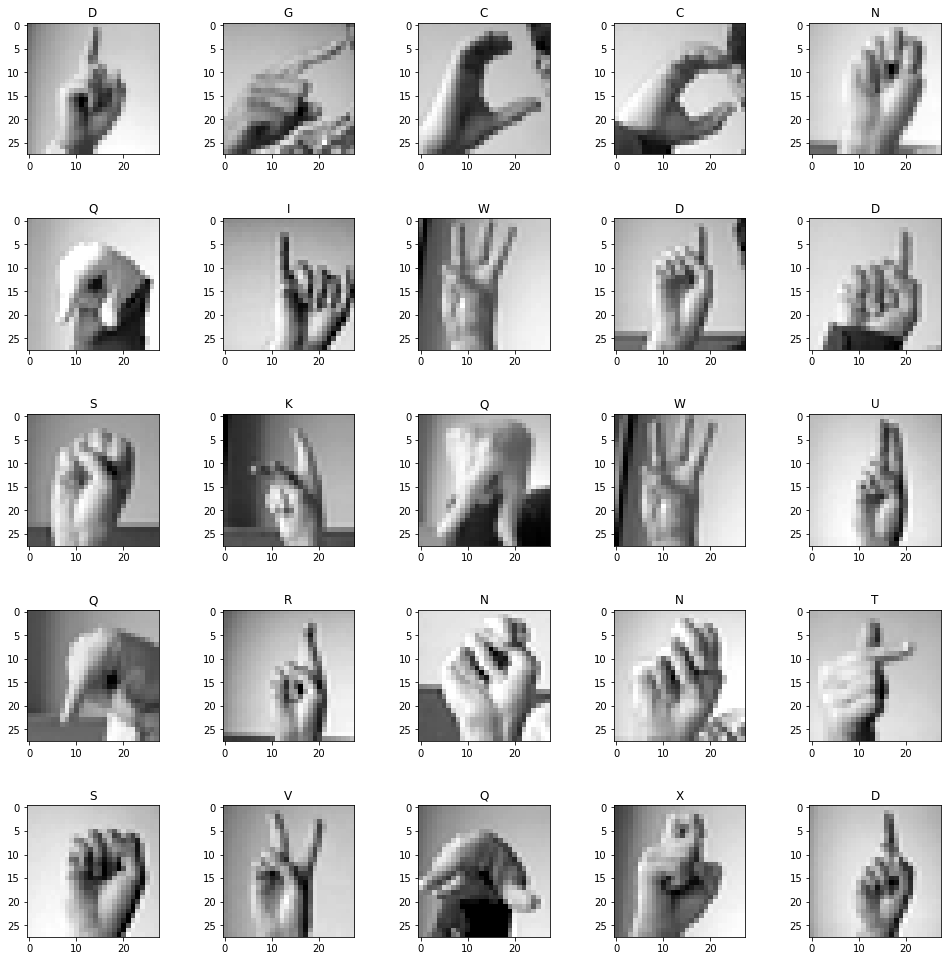

In [5]:
fig , ax = plt.subplots(nrows=5, ncols= 5, figsize = (14, 14))
ax = ax.flatten()
fig.tight_layout(pad=3.0)
for i, a in enumerate(ax):   
    a.imshow(data.values[i][:].reshape(28, 28), cmap = 'gray')
    a.set(title = string.ascii_letters[26+labels[i]])

In [5]:
#splitting the data
X_train, X_validation, y_train, y_validation = train_test_split(data, labels,test_size = 0.2, random_state = 123)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_validation = lb.transform(y_validation)
y_test = lb.transform(labels_t)

In [6]:
#features of model
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]
num_layers_0 = 1024
num_layers_1 = 1024
num_layers_2 = 1024
num_layers_3 = 1024
starter_learning_rate = 0.0005
starter_learning_rate2 = 0.025

In [7]:
#inputs and outputs
X_in = tf.placeholder('float32',shape =(None,num_features),name="X_in")
y_in = tf.placeholder('float32',shape = (None,num_classes),name='y_in')

In [8]:
# Weights initialized by random normal function with std_dev = sqrt(4/(number of input features+ number of output features)
with tf.name_scope('layer1'):
  weights_0 = tf.Variable(tf.random_normal([num_features,num_layers_0], stddev=(tf.sqrt(4/float(num_features + num_layers_0 )))))
  bias_0 = tf.Variable(tf.random_normal([num_layers_0]))
  tf.summary.histogram('W1',weights_0)
  tf.summary.histogram('b1',bias_0)
with tf.name_scope('layer2'):
  weights_1 = tf.Variable(tf.random_normal([num_layers_0,num_layers_1], stddev=(tf.sqrt(4/float(num_layers_0 + num_layers_1)))))
  bias_1 = tf.Variable(tf.random_normal([num_layers_1]))
  tf.summary.histogram('W2',weights_1)
  tf.summary.histogram('b2',bias_1)
with tf.name_scope('layer3'):
  weights_2 = tf.Variable(tf.random_normal([num_layers_1,num_layers_2], stddev=(tf.sqrt(4/float(num_layers_1 + num_layers_2 )))))
  bias_2 = tf.Variable(tf.random_normal([num_layers_2]))
  tf.summary.histogram('W3',weights_2)
  tf.summary.histogram('b3',bias_2)
with tf.name_scope('layer4'):
  weights_3 = tf.Variable(tf.random_normal([num_layers_2,num_layers_3], stddev=(tf.sqrt(4/float(num_layers_2 + num_layers_3)))))
  bias_3 = tf.Variable(tf.random_normal([num_layers_3]))
  tf.summary.histogram('W4',weights_3)
  tf.summary.histogram('b4',bias_3)
with tf.name_scope('layer5'):
  weights_4 = tf.Variable(tf.random_normal([num_layers_3,num_output], stddev=(tf.sqrt(1/float(num_layers_3 )))))
  bias_4 = tf.Variable(tf.random_normal([num_output]))
  tf.summary.histogram('W5',weights_4)
  tf.summary.histogram('b5',bias_4)

In [9]:
# Initializing weigths and biases
hidden_output_0 = tf.nn.relu(tf.matmul(X_in,weights_0)   +bias_0)
hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0,weights_1)  +bias_1)
hidden_output_2 = tf.nn.relu(tf.matmul(hidden_output_1,weights_2) +bias_2)
hidden_output_3 = tf.nn.relu(tf.matmul(hidden_output_2,weights_3) +bias_3)
y_pred = tf.sigmoid(tf.matmul(hidden_output_3,weights_4) +bias_4)

In [10]:
with tf.name_scope('loss'):
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred,labels=y_in))
  tf.summary.scalar('loss', loss)

In [11]:
#learning rate of Dynamic type
with tf.name_scope('learning_rate'):
  learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 8, 0.965, staircase=True)
  learning_rate2 = tf.train.exponential_decay(starter_learning_rate, 0, 4, 0.95, staircase=True)
  tf.summary.scalar('learning_rate', learning_rate)

# Note:
Take into note that learning rate is set dynamically and decays over the epoches so the learning process is done much more better!

In [12]:
# Adam optimzer for finding the right weight

#Two optimizers are set on our network at the first place 

optimizer_adam = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2,weights_3,weights_4,
                                                                         bias_0,bias_1,bias_2, bias_3,bias_4])
optimizer_sgd = tf.train.GradientDescentOptimizer(starter_learning_rate2).minimize(loss,var_list=[weights_0,weights_1,weights_2, weights_3,
                                                                         bias_0,bias_1,bias_2, bias_3])


In [13]:
#calculating accuaracy
with tf.name_scope('accuracy'):
  correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(y_pred,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', accuracy)

In [14]:
#splitting train and test
X_train, X_validation= X_train.values, X_validation.values
X_test = data_test.values

In [16]:
def augmentor(arr):
  batch_1 = np.random.choice(range(0, len(X_train)), size = 100)
  for j in range(100):
    arr[batch_1[j], :] = (np.flip((arr[batch_1[j], :].reshape(28, 28)), axis = 1)).reshape(1, -1)
  
  batch_2 = np.random.choice(range(0, len(X_train)), size = 100)
  dataset = tf.placeholder(tf.float32, [None, 28*28])
  images = tf.reshape(dataset, (-1, 28, 28,1))
  random_angles = tf.random.uniform(shape = (100, ), minval = -np
    .pi / 4, maxval = np.pi / 4)

  rotated_images = tf.contrib.image.transform(
    images,
    tf.contrib.image.angles_to_projective_transforms(
        random_angles, tf.cast(28, tf.float32), tf.cast(28, tf.float32)
    ))
  arr[batch_2, :] = s.run(rotated_images, feed_dict = {dataset : arr[batch_2,:]}).reshape(-1, 28*28)
  
  
  batch_31 = np.random.choice(range(0, len(X_train)), size = 100)
  batch_3 = np.random.randint(0, 10, size = (100, 2))
  for i in range(100):
    l = arr[batch_31[i], :].reshape(28, 28)
    arr[batch_31[i], :] = np.array(Image.fromarray(l[batch_3[i,0]:batch_3[i,0]+18, batch_3[i,1]:batch_3[i,1]+18]).resize((28, 28), Image.ANTIALIAS)).reshape(1, -1)
  return arr


In [17]:
X_t = augmentor(X_train.copy())

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# ADAM without batch normalization or dropout
# Note that this is my model which gets accuracy test of (depends on random state of shuffle) 85 to 87 %
> ****** Important

In [15]:
time_string = datetime.datetime.now().isoformat()
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/adam_without_dp_or_bn/' + current_time + '/train'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(train_log_dir, s.graph)

In [16]:
# Training parameters with adam optimizer and without Dropout
batch_size = 170
epochs= 40
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
tt_accuracy = []
tt_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer_adam, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:]} )
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train}))
    
            
    summary = s.run(merged, feed_dict= {X_in:X_train, 
                                        y_in: y_train})
    train_writer.add_summary(summary, epoch)
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation}))
    tt_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(y_pred, {X_in: X_test}).argmax(1)))
    tt_loss.append(s.run(loss, {X_in: X_test, 
                                      y_in: y_test}))
    print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}, tt acc : {tt_accuracy[epoch]}, tt loss: {tt_loss[epoch]}")
train_writer.close()

Epoch:0, Train loss: 2.58 Train acc: 0.363, Test acc:0.362, tt acc : 0.29963747908533184, tt loss: 2.616325616836548
Epoch:1, Train loss: 2.44 Train acc: 0.530, Test acc:0.517, tt acc : 0.43084216397099834, tt loss: 2.523118257522583
Epoch:2, Train loss: 2.37 Train acc: 0.721, Test acc:0.716, tt acc : 0.5630228667038483, tt loss: 2.44627046585083
Epoch:3, Train loss: 2.36 Train acc: 0.733, Test acc:0.742, tt acc : 0.6121026213050753, tt loss: 2.47930908203125
Epoch:4, Train loss: 2.33 Train acc: 0.812, Test acc:0.813, tt acc : 0.6671779141104295, tt loss: 2.4573564529418945
Epoch:5, Train loss: 2.36 Train acc: 0.751, Test acc:0.754, tt acc : 0.6409648633575014, tt loss: 2.4823272228240967
Epoch:6, Train loss: 2.31 Train acc: 0.852, Test acc:0.848, tt acc : 0.7052426101505856, tt loss: 2.444573163986206
Epoch:7, Train loss: 2.29 Train acc: 0.898, Test acc:0.899, tt acc : 0.7389849414389291, tt loss: 2.452866554260254
Epoch:8, Train loss: 2.31 Train acc: 0.872, Test acc:0.870, tt acc : 0

# Note on accuaracy of model
> take into account that accuracy of model(train and test) in adam optimizer can go up to 0.93 depending on the random state we are in and in different running and is varaiable between 0.78 and 0.95



Train Accuracy: 0.99
Test Accuracy:0.99
Train Loss: 2.25
Test Loss:2.25


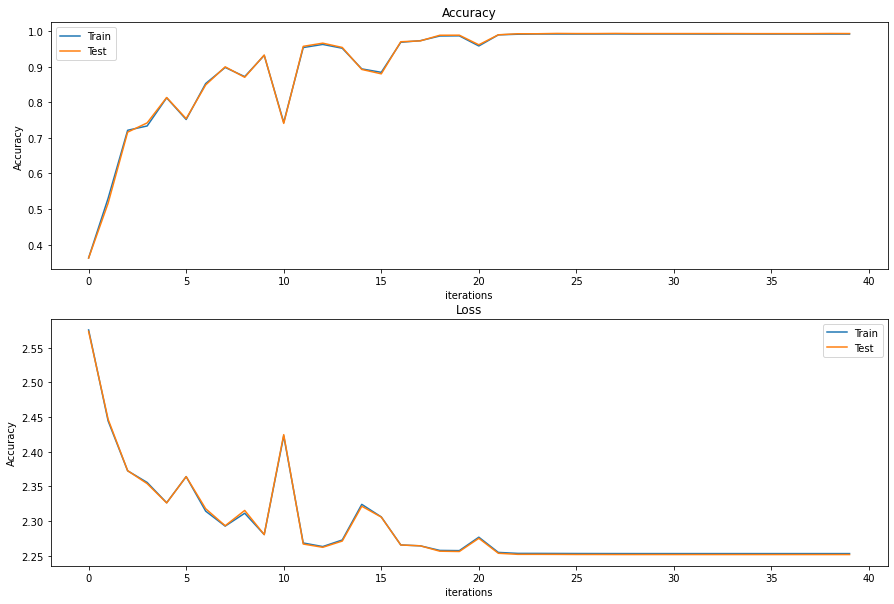

In [17]:
iterations = list(range(epochs))
fig, ax = plt.subplots(nrows = 2, ncols=1,figsize = (15, 10))
ax[0].plot(iterations, training_accuracy, label='Train')
ax[0].plot(iterations, testing_accuracy, label='Test')
ax[0].set(title = 'Accuracy',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[0].legend()
ax[1].plot(iterations, training_loss, label='Train')
ax[1].plot(iterations, testing_loss, label='Test')
ax[1].set(title = 'Loss',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[1].legend()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))
print("Train Loss: {0:.2f}".format(training_loss[-1]))
print("Test Loss:{0:.2f}".format(testing_loss[-1]))

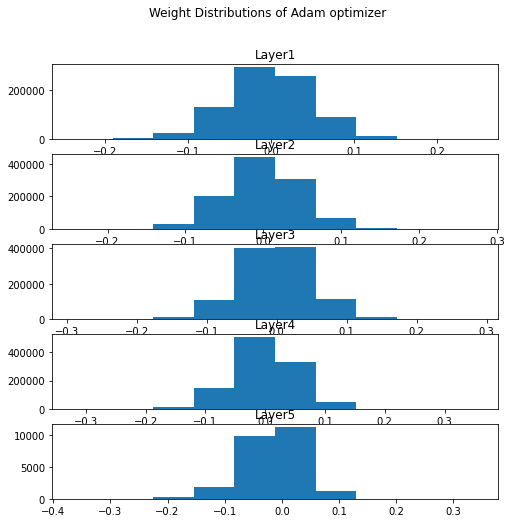

In [19]:
fig, ax = plt.subplots(nrows = 5, ncols=1,figsize = (8, 8))
for i, a in enumerate(ax):   
    if i==0:
      a.hist(s.run(weights_0).reshape(-1,1), bins = 10)
    elif i==1:
      a.hist(s.run(weights_1).reshape(-1,1), bins = 10)
    elif i==2 : 
      a.hist(s.run(weights_2).reshape(-1,1), bins = 10)
    elif i==3:
      a.hist(s.run(weights_3).reshape(-1,1), bins = 10)
    elif i==4:
      a.hist(s.run(weights_4).reshape(-1,1), bins = 10)
    a.set(title = 'Layer' + str(i+1))
fig.suptitle('Weight Distributions of Adam optimizer');

# SGD without batch normalization or dropout



In [20]:
time_string = datetime.datetime.now().isoformat()
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/sgd_without_dp_or_bn/' + current_time + '/train'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(train_log_dir, s.graph)

In [21]:
# Training parameters with sgd potimizer and without dropout
X_train = X_train + (0.35)*np.random.randn(X_train.shape[0],X_train.shape[1])
batch_size = 170
epochs=250
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
tt_accuracy = []
tt_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
       s.run(optimizer_sgd, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:]} )
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train}))
    
    summary = s.run(merged, feed_dict= {X_in:X_train, 
                                        y_in: y_train})
    train_writer.add_summary(summary, epoch)
    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation}))
    tt_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(y_pred, {X_in: X_test}).argmax(1)))
    tt_loss.append(s.run(loss, {X_in: X_test, 
                                      y_in: y_test}))
    if epoch%10 == 0:
      print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}, tt acc : {tt_accuracy[epoch]}, tt loss: {tt_loss[epoch]}")
train_writer.close()

Epoch:0, Train loss: 3.13 Train acc: 0.095, Test acc:0.126, tt acc : 0.10164528722810931, tt loss: 3.1538665294647217
Epoch:10, Train loss: 2.70 Train acc: 0.349, Test acc:0.398, tt acc : 0.31678750697155605, tt loss: 2.705453634262085
Epoch:20, Train loss: 2.61 Train acc: 0.426, Test acc:0.491, tt acc : 0.41731734523145564, tt loss: 2.617081880569458
Epoch:30, Train loss: 2.57 Train acc: 0.457, Test acc:0.524, tt acc : 0.4732292247629671, tt loss: 2.576312303543091
Epoch:40, Train loss: 2.54 Train acc: 0.489, Test acc:0.558, tt acc : 0.43530395984383713, tt loss: 2.5642998218536377
Epoch:50, Train loss: 2.51 Train acc: 0.503, Test acc:0.565, tt acc : 0.47769102063580593, tt loss: 2.5486669540405273
Epoch:60, Train loss: 2.49 Train acc: 0.552, Test acc:0.640, tt acc : 0.5370886781929727, tt loss: 2.5333681106567383
Epoch:70, Train loss: 2.47 Train acc: 0.548, Test acc:0.629, tt acc : 0.502649191299498, tt loss: 2.524576425552368
Epoch:80, Train loss: 2.46 Train acc: 0.578, Test acc:0.6

Train Accuracy: 0.73
Test Accuracy:0.80
Train Loss: 2.34
Test Loss:2.36


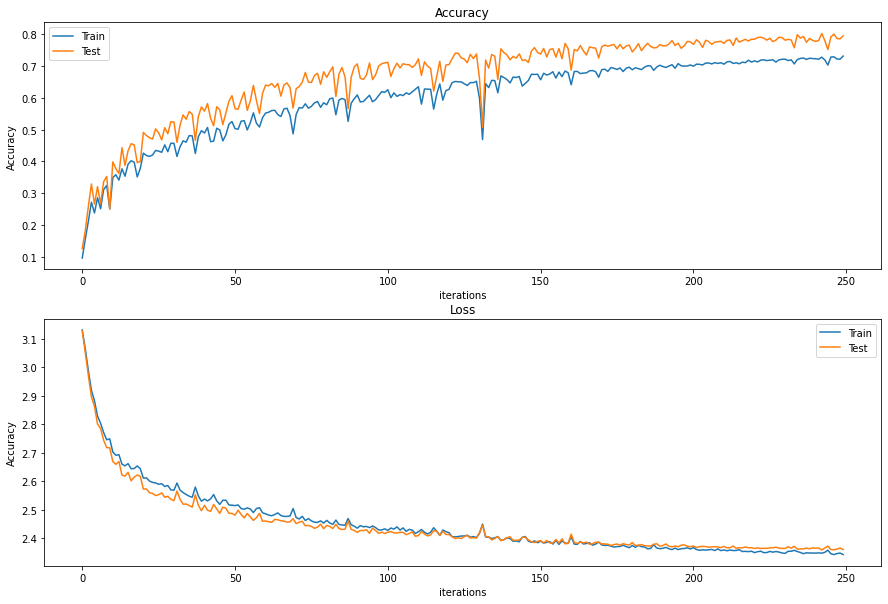

In [22]:
iterations = list(range(epochs))
fig, ax = plt.subplots(nrows = 2, ncols=1,figsize = (15, 10))
ax[0].plot(iterations, training_accuracy, label='Train')
ax[0].plot(iterations, testing_accuracy, label='Test')
ax[0].set(title = 'Accuracy',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[0].legend()
ax[1].plot(iterations, training_loss, label='Train')
ax[1].plot(iterations, testing_loss, label='Test')
ax[1].set(title = 'Loss',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[1].legend()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))
print("Train Loss: {0:.2f}".format(training_loss[-1]))
print("Test Loss:{0:.2f}".format(testing_loss[-1]))

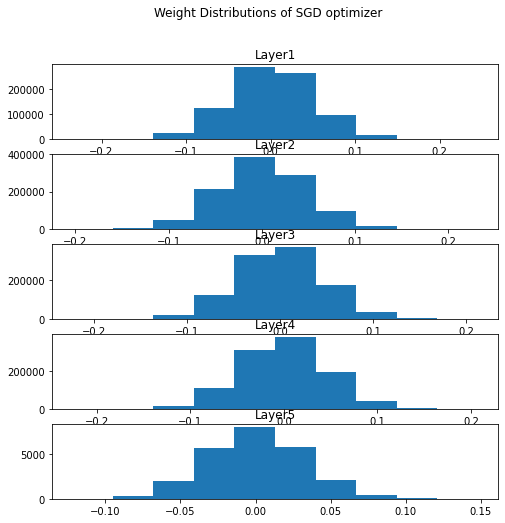

In [23]:
fig, ax = plt.subplots(nrows = 5, ncols=1,figsize = (8, 8))
for i, a in enumerate(ax):   
    if i==0:
      a.hist(s.run(weights_0).reshape(-1,1), bins = 10)
    elif i==1:
      a.hist(s.run(weights_1).reshape(-1,1), bins = 10)
    elif i==2 : 
      a.hist(s.run(weights_2).reshape(-1,1), bins = 10)
    elif i==3:
      a.hist(s.run(weights_3).reshape(-1,1), bins = 10)
    elif i==4:
      a.hist(s.run(weights_4).reshape(-1,1), bins = 10)
    a.set(title = 'Layer' + str(i+1))
fig.suptitle('Weight Distributions of SGD optimizer');

#Compare of sgd. and adam and propose new optimzers

Conclusion is that sgd is clearly a late-converger compared to adam at least in task of classification and also is so senssative to global minima so we had to add noise tp our data in order toi make it move. and Also as a proposal for new optimizers we can use newton or 2-nd order methods os momentum and rmsprop which are kinda like adam but with tuning of hyperparametes can perform better and also one strong optimizer in task of classification which is NadimOptimizer which is not implemented in tensorflow without keras so we couldnt use it .


# Adding dropout to model

In [17]:
keep_prob = tf.placeholder(tf.float32)

In [46]:
#adding Dropout to the model
with tf.name_scope('DropOut'):
  hidden_output_0 = tf.nn.relu(tf.matmul(X_in,weights_0)   +bias_0)
  hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0,weights_1)  +bias_1)
  hidden_output_1_1 = tf.nn.dropout(hidden_output_1, keep_prob)
  tf.summary.histogram('hidden_1', hidden_output_1_1)
  hidden_output_2 = tf.nn.relu(tf.matmul(hidden_output_1_1,weights_2) +bias_2)
  hidden_output_3 = tf.nn.relu(tf.matmul(hidden_output_2_2,weights_3) +bias_3)
  hidden_output_3_3 = tf.nn.dropout(hidden_output_3, keep_prob)
  tf.summary.histogram('hidden_2', hidden_output_3_3)
y_pred = tf.sigmoid(tf.matmul(hidden_output_3_3,weights_4)+ bias_4)

# Adam with dropout and without batch normalization

In [47]:
time_string = datetime.datetime.now().isoformat()
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/adam_with_dp_without_bn/' + current_time + '/train'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(train_log_dir, s.graph)

In [48]:
#tuning parameters with dropout and adam optimizer
batch_size = 170
epochs=40
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
tt_accuracy = []
tt_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer_adam , {X_in: X_train[arr[index:index+batch_size]],
                          y_in: y_train[arr[index:index+batch_size]],
                        keep_prob:dropout_prob})
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train,keep_prob:1}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train,keep_prob:1}))
    
    summary = s.run(merged, feed_dict= {X_in:X_train, 
                                        y_in: y_train, keep_prob:1})
    train_writer.add_summary(summary, epoch)

    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation,keep_prob:1}))
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation,keep_prob:1}).argmax(1)))


    tt_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(y_pred, {X_in: X_test, keep_prob:1}).argmax(1)))
    tt_loss.append(s.run(loss, {X_in: X_test, 
                                      y_in: y_test, keep_prob :1}))
    print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}, tt acc : {tt_accuracy[epoch]}, tt loss: {tt_loss[epoch]}")
train_writer.close()

Epoch:0, Train loss: 2.67 Train acc: 0.264, Test acc:0.290, tt acc : 0.25418293363078637, tt loss: 2.687520742416382
Epoch:1, Train loss: 2.58 Train acc: 0.386, Test acc:0.424, tt acc : 0.37325711098717235, tt loss: 2.6025149822235107
Epoch:2, Train loss: 2.56 Train acc: 0.457, Test acc:0.500, tt acc : 0.4196876742889013, tt loss: 2.6011319160461426
Epoch:3, Train loss: 2.49 Train acc: 0.534, Test acc:0.607, tt acc : 0.5248187395426659, tt loss: 2.5010533332824707
Epoch:4, Train loss: 2.46 Train acc: 0.572, Test acc:0.635, tt acc : 0.5585610708310095, tt loss: 2.4743738174438477
Epoch:5, Train loss: 2.44 Train acc: 0.627, Test acc:0.723, tt acc : 0.6229782487451199, tt loss: 2.4532577991485596
Epoch:6, Train loss: 2.43 Train acc: 0.600, Test acc:0.656, tt acc : 0.5492191857222533, tt loss: 2.471956253051758
Epoch:7, Train loss: 2.42 Train acc: 0.630, Test acc:0.688, tt acc : 0.5825432236475181, tt loss: 2.467752695083618
Epoch:8, Train loss: 2.38 Train acc: 0.708, Test acc:0.771, tt ac

Train Accuracy: 0.95
Test Accuracy:0.95
Train Loss: 2.27
Test Loss:2.27


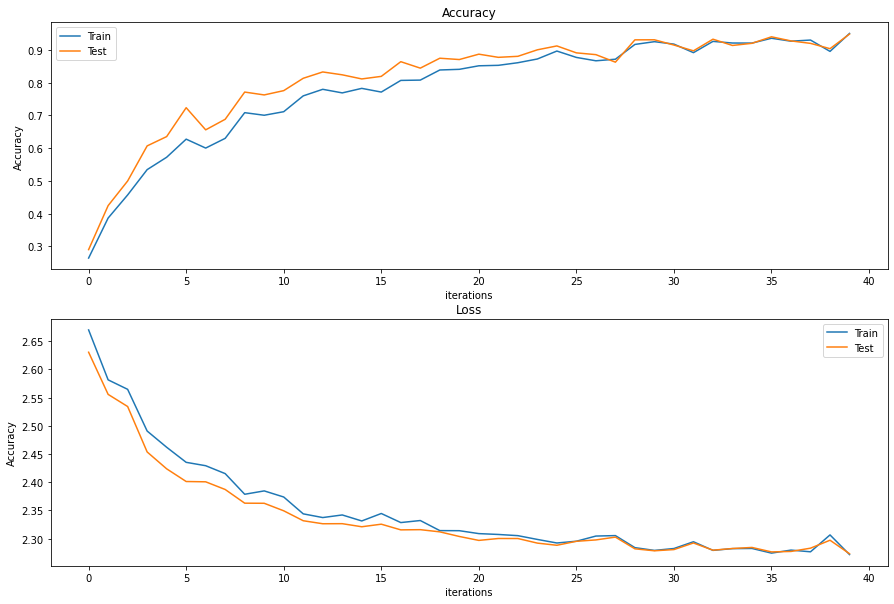

In [49]:
iterations = list(range(epochs))
fig, ax = plt.subplots(nrows = 2, ncols=1,figsize = (15, 10))
ax[0].plot(iterations, training_accuracy, label='Train')
ax[0].plot(iterations, testing_accuracy, label='Test')
ax[0].set(title = 'Accuracy',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[0].legend()
ax[1].plot(iterations, training_loss, label='Train')
ax[1].plot(iterations, testing_loss, label='Test')
ax[1].set(title = 'Loss',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[1].legend()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))
print("Train Loss: {0:.2f}".format(training_loss[-1]))
print("Test Loss:{0:.2f}".format(testing_loss[-1]))

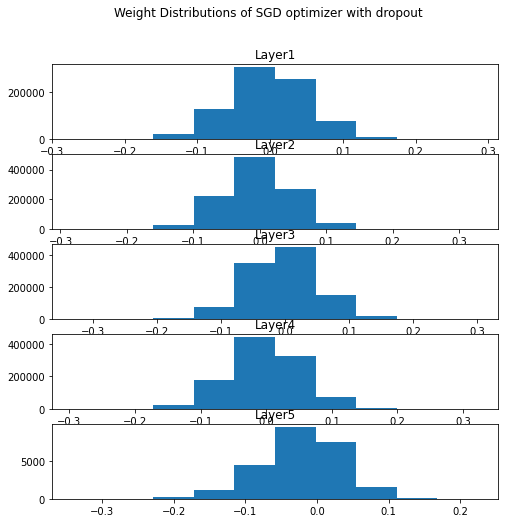

In [50]:
fig, ax = plt.subplots(nrows = 5, ncols=1,figsize = (8, 8))
for i, a in enumerate(ax):   
    if i==0:
      a.hist(s.run(weights_0).reshape(-1,1), bins = 10)
    elif i==1:
      a.hist(s.run(weights_1).reshape(-1,1), bins = 10)
    elif i==2 : 
      a.hist(s.run(weights_2).reshape(-1,1), bins = 10)
    elif i==3:
      a.hist(s.run(weights_3).reshape(-1,1), bins = 10)
    elif i==4:
      a.hist(s.run(weights_4).reshape(-1,1), bins = 10)
    a.set(title = 'Layer' + str(i+1))
fig.suptitle('Weight Distributions of SGD optimizer with dropout');

 # جواب بخش پ  
We can clearly see that distribution of weights after adding dropout goes through a decrease in number of weights centered in the gaussian curve we have which was normal and expected.
and about the loss and accuracy curve we see that there were minor fluctutations in these curves before adding dropout which was kinda solved and smoothed with adding dropout to our model 
but generally drop out specially on deep networks (which is not the case of our model) has beed proved to work out quite well

# SGD with drop out and without batch nornmalization

In [74]:
time_string = datetime.datetime.now().isoformat()
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/sgd_with_dp_without_bn/' + current_time + '/train'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(train_log_dir, s.graph)

In [75]:
# Training parameters with dropout and sgd optimizer
X_train = X_train + (0.35)*np.random.randn(X_train.shape[0],X_train.shape[1])
batch_size = 128
epochs=250
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
       s.run(optimizer_sgd, {X_in: X_train[arr[index:index+batch_size]][:],
                          y_in: y_train[arr[index:index+batch_size]][:], keep_prob:dropout_prob} )
    training_accuracy.append(s.run(accuracy, feed_dict= {X_in:X_train, 
                                                         y_in: y_train, keep_prob:1}))
    training_loss.append(s.run(loss, {X_in: X_train, 
                                      y_in: y_train, keep_prob:1}))
    summary = s.run(merged, feed_dict= {X_in:X_train, 
                                        y_in: y_train, keep_prob:1})
    train_writer.add_summary(summary, epoch)

    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred, {X_in: X_validation, keep_prob:1}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation, 
                                      y_in: y_validation, keep_prob:1}))
    if epoch%10 == 0:
      print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")
train_writer.close()

Epoch:0, Train loss: 3.13 Train acc: 0.079, Test acc:0.110
Epoch:10, Train loss: 2.73 Train acc: 0.331, Test acc:0.415
Epoch:20, Train loss: 2.65 Train acc: 0.378, Test acc:0.479
Epoch:30, Train loss: 2.59 Train acc: 0.430, Test acc:0.507
Epoch:40, Train loss: 2.55 Train acc: 0.455, Test acc:0.554
Epoch:50, Train loss: 2.52 Train acc: 0.461, Test acc:0.540
Epoch:60, Train loss: 2.50 Train acc: 0.476, Test acc:0.563
Epoch:70, Train loss: 2.47 Train acc: 0.499, Test acc:0.591
Epoch:80, Train loss: 2.47 Train acc: 0.504, Test acc:0.543
Epoch:90, Train loss: 2.44 Train acc: 0.521, Test acc:0.603
Epoch:100, Train loss: 2.44 Train acc: 0.534, Test acc:0.626
Epoch:110, Train loss: 2.42 Train acc: 0.542, Test acc:0.599
Epoch:120, Train loss: 2.41 Train acc: 0.558, Test acc:0.628
Epoch:130, Train loss: 2.40 Train acc: 0.565, Test acc:0.624
Epoch:140, Train loss: 2.40 Train acc: 0.575, Test acc:0.610
Epoch:150, Train loss: 2.40 Train acc: 0.585, Test acc:0.633
Epoch:160, Train loss: 2.39 Train a

Train Accuracy: 0.66
Test Accuracy:0.65
Train Loss: 2.36
Test Loss:2.49


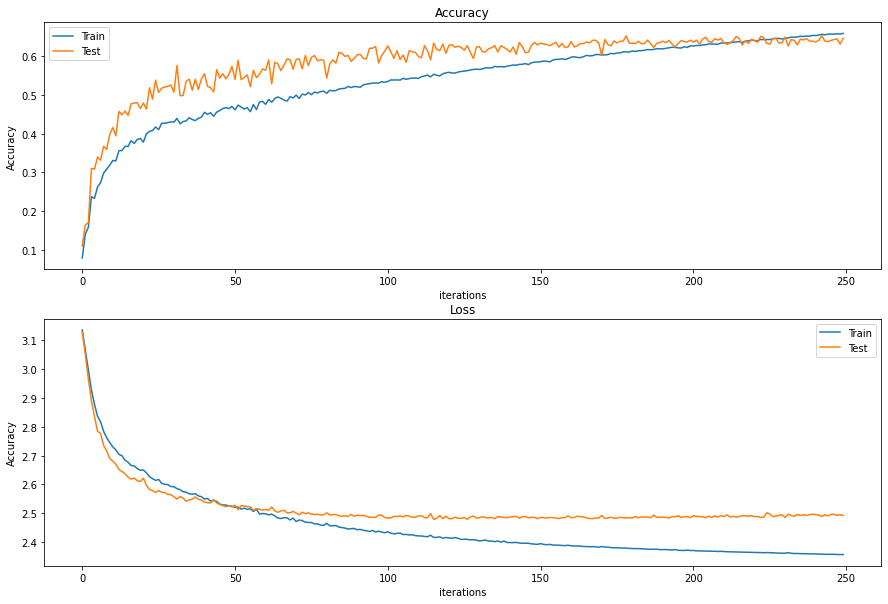

In [76]:
iterations = list(range(epochs))
fig, ax = plt.subplots(nrows = 2, ncols=1,figsize = (15, 10))
ax[0].plot(iterations, training_accuracy, label='Train')
ax[0].plot(iterations, testing_accuracy, label='Test')
ax[0].set(title = 'Accuracy',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[0].legend()
ax[1].plot(iterations, training_loss, label='Train')
ax[1].plot(iterations, testing_loss, label='Test')
ax[1].set(title = 'Loss',
       ylabel= ('Accuracy'), 
       xlabel = ('iterations'))
ax[1].legend()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))
print("Train Loss: {0:.2f}".format(training_loss[-1]))
print("Test Loss:{0:.2f}".format(testing_loss[-1]))

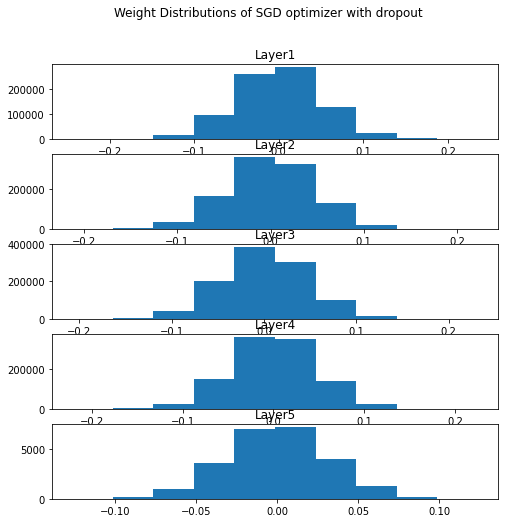

In [77]:
fig, ax = plt.subplots(nrows = 5, ncols=1,figsize = (8, 8))
for i, a in enumerate(ax):   
    if i==0:
      a.hist(s.run(weights_0).reshape(-1,1), bins = 10)
    elif i==1:
      a.hist(s.run(weights_1).reshape(-1,1), bins = 10)
    elif i==2 : 
      a.hist(s.run(weights_2).reshape(-1,1), bins = 10)
    elif i==3:
      a.hist(s.run(weights_3).reshape(-1,1), bins = 10)
    elif i==4:
      a.hist(s.run(weights_4).reshape(-1,1), bins = 10)
    a.set(title = 'Layer' + str(i+1))
fig.suptitle('Weight Distributions of SGD optimizer with dropout');

# Conclusion 

we can see that adding dropput despite our expectation to perform better didnt perform the model accuarcy so much and we still got the same results and even better results before dropout which is a wonder !!! and also after experiment i concluded using it in few of our layers performs better than using it all over our model

# Adding batch normalization to model

In [19]:


#adding Dropout to the model
hidden_output_0 = tf.nn.relu(tf.matmul(X_in,weights_0)   +bias_0)
hidden_output_0_0 = tf.nn.dropout(hidden_output_0, keep_prob)
batchNorm_0 = tf.layers.batch_normalization(hidden_output_0_0,  momentum=0.9)
hidden_output_1 = tf.nn.relu(tf.matmul(batchNorm_0,weights_1)  +bias_1)
batchNorm_1 = tf.layers.batch_normalization(hidden_output_1,  momentum=0.9)
hidden_output_2 = tf.nn.relu(tf.matmul(batchNorm_1,weights_2) +bias_2)
batchNorm_2 = tf.layers.batch_normalization(hidden_output_2,  momentum=0.9)
hidden_output_3 = tf.nn.relu(tf.matmul(batchNorm_2,weights_3) +bias_3)
hidden_output_3_3 = tf.nn.dropout(hidden_output_3, keep_prob)
batchNorm_3 = tf.layers.batch_normalization(hidden_output_3_3,  momentum=0.9)
y_pred_1 = tf.sigmoid(tf.matmul(batchNorm_3,weights_4)+ bias_4)




In [20]:
loss_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred_1,labels=y_in))
optimizer_adam_1 = tf.train.AdamOptimizer(learning_rate).minimize(loss_1,var_list=[weights_0,weights_1,weights_2,weights_3,weights_4,
                                                                         bias_0,bias_1,bias_2, bias_3,bias_4])

In [21]:
correct_prediction_2 = tf.equal(tf.argmax(y_train,1), tf.argmax(y_pred_1,1))
accuracy_2 = tf.reduce_mean(tf.cast(correct_prediction_2, tf.float32))

# ADAm with dropout and batch normalization

In [15]:
time_string = datetime.datetime.now().isoformat()
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/adam_with_dp_with_bn/' + current_time + '/train'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(train_log_dir, s.graph)

In [23]:

batch_size = 170
epochs= 40
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
tt_accuracy = []
tt_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer_adam_1 ,feed_dict =  {X_in: X_train[arr[index:index+batch_size]][:],
                                           y_in: y_train[arr[index:index+batch_size]][:],
                                            keep_prob:dropout_prob})
        
    training_accuracy.append(s.run(accuracy_2, feed_dict= {X_in:X_train, 
                                                         y_in: y_train, keep_prob:1}))
    training_loss.append(s.run(loss_1, {X_in: X_train, 
                                      y_in: y_train, keep_prob:1}))
    
    summary = s.run(merged, feed_dict= {X_in:X_train, 
                                        y_in: y_train, keep_prob:1})
    train_writer.add_summary(summary, epoch)
    
#Evaluate
    testing_accuracy.append(accuracy_score(y_validation.argmax(1), 
                            s.run(y_pred_1, {X_in: X_validation, keep_prob:1}).argmax(1)))
    testing_loss.append(s.run(loss_1, {X_in: X_validation, 
                                      y_in: y_validation, keep_prob:1}))
    

    tt_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(y_pred_1, {X_in: X_test, keep_prob:1}).argmax(1)))
    tt_loss.append(s.run(loss_1, {X_in: X_test, 
                                      y_in: y_test, keep_prob:1}))
    print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}, tt acc : {tt_accuracy[epoch]}, tt loss: {tt_loss[epoch]}")
train_writer.close()

Epoch:0, Train loss: 2.72 Train acc: 0.246, Test acc:0.250, tt acc : 0.20942554378137201, tt loss: 2.7465460300445557
Epoch:1, Train loss: 2.57 Train acc: 0.372, Test acc:0.367, tt acc : 0.32431678750697157, tt loss: 2.602541208267212
Epoch:2, Train loss: 2.49 Train acc: 0.440, Test acc:0.437, tt acc : 0.3993307306190742, tt loss: 2.547137975692749
Epoch:3, Train loss: 2.44 Train acc: 0.513, Test acc:0.501, tt acc : 0.4274958170663692, tt loss: 2.4948532581329346
Epoch:4, Train loss: 2.44 Train acc: 0.567, Test acc:0.561, tt acc : 0.5009760178471835, tt loss: 2.5208234786987305
Epoch:5, Train loss: 2.41 Train acc: 0.621, Test acc:0.618, tt acc : 0.5267707752370329, tt loss: 2.477814197540283
Epoch:6, Train loss: 2.39 Train acc: 0.636, Test acc:0.631, tt acc : 0.5645566090351366, tt loss: 2.4711225032806396
Epoch:7, Train loss: 2.39 Train acc: 0.682, Test acc:0.676, tt acc : 0.6111266034578918, tt loss: 2.4483654499053955
Epoch:8, Train loss: 2.36 Train acc: 0.739, Test acc:0.738, tt ac

# Conclusion

generally we expect batch normalization to increase the performance of our model but since implementation of our model it self is no oridniary implementation (4*1024) neuron layers so still the performance is still the same with the state of no batch normalization

# Evaluating before and after unabalcing the dataset

In [24]:
a = tf.math.confusion_matrix(y_test.argmax(1),s.run(y_pred, {X_in: X_test}).argmax(1) )
b = a.eval()
b

array([[331,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 432,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 310,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 206,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  21,   0,   0,   0,   0,   0,  18,   0],
       [  0,   0,   0,   0, 498,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  21,   0,   0, 206,   0,   0,   0,  20,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  13, 285,  24,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   6,   0,   0,   0,  20,   0],
       [  0,   0,   0,   0,   0,   0,  20

In [25]:
b = np.einsum('ii -> i', b)
b = b.argmax()
b

4

In [27]:
data_1 = pd.read_csv('/content/drive/My Drive/DL-HW1/Q1_train.csv')
data_test_1 = pd.read_csv('/content/drive/My Drive/DL-HW1/Q1_test.csv')
k = data_1[data_1.iloc[:,0]== b]
data_1.drop(index= k.index, inplace = True)
data_1.reset_index(drop=True)
k.reset_index(drop = True)
c = np.random.choice(range(k.shape[0]), size = int(k.shape[0]/5))
k = k.iloc[c,:]
data_1 = data_1.append(k, ignore_index = True)

In [28]:
labels_1 = data_1.iloc[:,0]
labels_t_1 = data_test_1.iloc[:,0]
data_1.drop(columns = ['label'],inplace = True)
data_test_1.drop(columns = ['label'],inplace = True)
#standarizing
data_1 = data_1/255
data_test_1 = data_test_1/255

In [34]:
X_train_1, X_validation_1, y_train_1, y_validation_1 = train_test_split(data_1, labels_1,test_size = 0.2, random_state = 123)
lb = LabelBinarizer()
y_train_1 = lb.fit_transform(y_train_1)
y_validation_1 = lb.transform(y_validation_1)
y_test_1 = lb.transform(labels_t)

In [36]:
#splitting train and test
X_train_1, X_validation_1= X_train_1.values, X_validation_1.values
X_test_1 = data_test_1.values

In [31]:
#calculating accuaracy
with tf.name_scope('accuracy_1'):
  correct_prediction_1 = tf.equal(tf.argmax(y_train_1,1), tf.argmax(y_pred,1))
  accuracy_1 = tf.reduce_mean(tf.cast(correct_prediction_1, tf.float32))
  tf.summary.scalar('accuracy_1', accuracy_1)

In [32]:
time_string = datetime.datetime.now().isoformat()
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/after/' + current_time + '/train'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(train_log_dir, s.graph)

In [24]:
batch_size = 170
epochs= 40
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
testing_loss = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train_1.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train_1.shape[0],batch_size):
        s.run(optimizer_adam, {X_in: X_train_1[arr[index:index+batch_size]][:],
                          y_in: y_train_1[arr[index:index+batch_size]][:]} )
    training_accuracy.append(s.run(accuracy_1, feed_dict= {X_in:X_train_1, 
                                                         y_in: y_train_1}))
    training_loss.append(s.run(loss, {X_in: X_train_1, 
                                      y_in: y_train_1}))
        
    summary = s.run(merged, feed_dict= {X_in:X_train_1, 
                                        y_in: y_train_1})
    train_writer.add_summary(summary, epoch)
    

#Evaluate
    testing_accuracy.append(accuracy_score(y_validation_1.argmax(1), 
                            s.run(y_pred, {X_in: X_validation_1}).argmax(1)))
    testing_loss.append(s.run(loss, {X_in: X_validation_1, 
                                      y_in: y_validation_1}))
  #  tt_accuracy.append(accuracy_score(y_test.argmax(1), 
  #                          s.run(y_pred, {X_in: X_test}).argmax(1)))
  #  tt_loss.append(s.run(loss, {X_in: X_test, 
  #                                    y_in: y_test}))
    print(f"Epoch:{epoch}, Train loss: {training_loss[epoch]:.2f} Train acc: {training_accuracy[epoch]:.3f}, Test acc:{testing_accuracy[epoch]:.3f}")
train_writer.close()

Epoch:0, Train loss: 3.15 Train acc: 0.040, Test acc:0.039
Epoch:1, Train loss: 2.66 Train acc: 0.203, Test acc:0.205
Epoch:2, Train loss: 2.50 Train acc: 0.424, Test acc:0.432
Epoch:3, Train loss: 2.42 Train acc: 0.555, Test acc:0.555
Epoch:4, Train loss: 2.41 Train acc: 0.599, Test acc:0.597
Epoch:5, Train loss: 2.35 Train acc: 0.744, Test acc:0.737
Epoch:6, Train loss: 2.36 Train acc: 0.743, Test acc:0.734
Epoch:7, Train loss: 2.34 Train acc: 0.771, Test acc:0.770
Epoch:8, Train loss: 2.31 Train acc: 0.846, Test acc:0.843
Epoch:9, Train loss: 2.30 Train acc: 0.867, Test acc:0.866
Epoch:10, Train loss: 2.32 Train acc: 0.828, Test acc:0.820
Epoch:11, Train loss: 2.30 Train acc: 0.882, Test acc:0.881
Epoch:12, Train loss: 2.28 Train acc: 0.922, Test acc:0.920
Epoch:13, Train loss: 2.30 Train acc: 0.900, Test acc:0.896
Epoch:14, Train loss: 2.29 Train acc: 0.922, Test acc:0.923
Epoch:15, Train loss: 2.29 Train acc: 0.916, Test acc:0.921
Epoch:16, Train loss: 2.28 Train acc: 0.938, Test 

In [37]:
a_1 = tf.math.confusion_matrix(y_test_1.argmax(1),s.run(y_pred, {X_in: X_test_1}).argmax(1) )
b_1 = a_1.eval()
b_1

array([[331,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 414,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  17,   0,   0,   0,   0],
       [  0,   0, 308,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 194,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  10,   0,   0,   0,   0,   0,  41,   0],
       [ 81,  18,   0,   0,   0,  20,   0,   0,   0,   0,   0, 107,  22,
         13,   0,   3,   0, 234,   0,   0,   0,   0,   0,   0],
       [  0,   0,  21,   0,   0, 210,   0,   0,   0,  16,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  18, 266,  22,   0,   0,   0,   0,  17,
          4,   0,  16,   0,   0,   1,   0,   0,   0,   4,   0],
       [  0,   0,   0,   0,   0,   0,  39

# Conclusion 
we can clearly see that the data which we deleted in the new confusion matrix have a really low true positive rate and also other true positive rated have changed a bit (increases or decreases)

> we can do variety of things to make this up one of which is under and oversampling which by their name is respectivevly decreasing other classes like we did with this class or increaseing rate of this class to what it was before by adding random copies of the data we already have it from it.

> other option is using varuational authoencoder which is. basically using to gropus of neurons known as mean and variance with gaussian distribution concatenated in one layer between two consecutive layers of our model and sampling from the output of this helpful layer so unbalanced dataset gets kinda balanced in term of uniform sampling
